# Finger Detection and Counting 

> This project identifies hand and detects total number of fingers in hand.

## Imports

In [1]:
import cv2 as cv
import numpy as np

# used for distance calculation
from sklearn.metrics import pairwise

## Global Variables

In [2]:
# This background will be a global variable that will be updated through a few functions
background = None

accumulated_weight = 0.25

# Manually setting up our ROI for grabbing the hand.
roi_top, roi_bottom, roi_right, roi_left = 20, 300, 300, 600

## Finding Average Background Value

The function calculates the weighted sum of the input image src and the accumulator dst so that dst becomes a running average of a frame sequence:

In [3]:
def calc_accum_avg(frame, accumulated_weight):
    '''
    Given a frame and a previous accumulated weight, computed the weighted average of the image passed in.
    '''
    
    global background
    
    if background is None:
        background = frame.copy().astype("float")
        return None

    # compute weighted average, accumulate it and update the background
    cv.accumulateWeighted(frame, background, accumulated_weight)

## Segment the Hand Region in Frame

In [4]:
def segment(frame, threshold=25):
    '''
    Given a frame returns the thresholded frame and largest contour of that frame.
    '''
    
    global background
    
    # Calculates the Absolute Difference between the backgroud and the passed in frame
    diff = cv.absdiff(background.astype("uint8"), frame)
    
    # Applying a threshold to the image so we can grab the foreground
    _ , thresholded = cv.threshold(src=diff, thresh=threshold, maxval=255, type=cv.THRESH_BINARY)
    
    # Grabbing the external contours form the image
    contours, _ = cv.findContours(image=thresholded.copy(), mode=cv.RETR_EXTERNAL, method=cv.CHAIN_APPROX_SIMPLE)
    
    if not len(contours):
        return None
    
    else:
        # Given the way we are using the program, the largest external contour should be the hand (largest by area)
        # This will be our segment
        hand_segment = max(contours, key=cv.contourArea)
        return (thresholded, hand_segment)

## Counting Fingers with a Convex Hull

We just calculated the external contour of the hand. Now using that segmented hand, let's see how to calculate fingers. Then we can count how many are up!

Example of ConvexHulls:

<img src="./hand_convex.png">

In [5]:
def count_fingers(thresholded, hand_segment):
    '''
    Given thresholded image of frame and hand segment calculates and returns total number of fingers.
    '''
    
    # Calculated the convex hull of the hand segment
    conv_hull = cv.convexHull(hand_segment)
    
    top    = tuple(conv_hull[conv_hull[:, :, 1].argmin()][0])
    bottom = tuple(conv_hull[conv_hull[:, :, 1].argmax()][0])
    left   = tuple(conv_hull[conv_hull[:, :, 0].argmin()][0])
    right  = tuple(conv_hull[conv_hull[:, :, 0].argmax()][0])
    
    # In theory, the center of the hand is half way between the top and bottom and halfway between left and right
    cX = (left[0] + right[0]) // 2
    cY = (top[1] + bottom[1]) // 2
    
    # Calculating the Euclidean Distance between the center of the hand and the left, right, top, and bottom.
    distance = pairwise.euclidean_distances(X=[(cX, cY)], Y=[left, right, top, bottom])[0]
    
    max_distance = distance.max()
    
    # Creating a circle with 90% radius of the max euclidean distance
    radius = int(0.8 * max_distance)
    circumference = 2 * np.pi * radius
    
    circular_roi = np.zeros(thresholded.shape[:2], dtype="uint8")
    
    cv.circle(img=circular_roi, center=(cX, cY), radius=radius, color=255, thickness=10)
    
    # Using bit-wise AND with the cirle ROI as a mask.
    # This then returns the cut out obtained using the mask on the thresholded hand image.
    circular_roi = cv.bitwise_and(src1=thresholded, src2=thresholded, mask=circular_roi)
    
    contours, hierarchy = cv.findContours(image=circular_roi.copy(), mode=cv.RETR_EXTERNAL, method=cv.CHAIN_APPROX_NONE)
    
    # Initial finger count
    count = 0
    
    # looping through the contours to see if we count any more fingers.
    for contour in contours:
        
        (x, y, w, h) = cv.boundingRect(contour)
        
        # Increment count of fingers based on two conditions:
        
        # 1. Contour region is not the very bottom of hand area (the wrist)
        out_of_wrist = ((cY + (cY * 0.25)) > (y + h))
        
        # 2. Number of points along the contour does not exceed 25% of the circumference of the circular ROI (otherwise we're counting points off the hand)
        limit_points = ((circumference * 0.25) > contour.shape[0])
        
        if out_of_wrist and limit_points:
            count += 1
            
    return count, contours, hierarchy

## Run Program

In [6]:
cam = cv.VideoCapture(0)

# Intialize a frame count
num_frames = 0

# Looping, until interrupted
while True:
    
    ret, frame = cam.read()
    
    # Flipping the frame so that it is not the mirror view
    frame = cv.flip(src=frame, flipCode=1)
    
    frame_copy = frame.copy()
    
    # Grabbing the ROI from the frame
    roi = frame[roi_top: roi_bottom, roi_right: roi_left]
    
    # Applying grayscale and blur to ROI
    gray = cv.cvtColor(src=roi, code=cv.COLOR_BGR2GRAY)
    gray = cv.GaussianBlur(src=gray, ksize=(7, 7), sigmaX=0)
    
    # For the first 60 frames we will calculate the average of the background.
    if num_frames < 60:
        
        calc_accum_avg(frame=gray, accumulated_weight=accumulated_weight)
        
        if num_frames <= 59:
            cv.putText(img=frame_copy, text="WAIT! GETTING BACKGROUND AVERAGE", org=(200, 400), fontFace=cv.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0, 0, 255), thickness=2)
            cv.imshow(winname="Finger Count", mat=frame_copy)
            
    else:
        # now that we have the background, we can segment the hand.
        
        # segment the hand region
        hand = segment(frame=gray)
        
        # First check if we were able to actually detect a hand
        if hand is not None:
            
            thresholded, hand_segment = hand
            
            cv.drawContours(image=frame_copy, contours=[hand_segment + (roi_right, roi_top)], contourIdx=-1, color=(255, 0, 0), thickness=1)
            
            # Counting the fingers
            fingers, contours, hierarchy = count_fingers(thresholded=thresholded, hand_segment=hand_segment)
            
            # Displaying count
            cv.putText(img=frame_copy, text=str(fingers), org=(70, 45), fontFace=cv.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0, 0, 255), thickness=2)
            
            # Also displaying the thresholded image for debugging.
            cv.imshow(winname="Thresholded", mat=thresholded)
          
    # Drawing ROI Rectangle on frame copy
    cv.rectangle(img=frame_copy, pt1=(roi_left, roi_top), pt2=(roi_right, roi_bottom), color=(0, 0, 255), thickness=5)
    
    # incrementing the number of frames for tracking
    num_frames += 1
    
    # Displaying the frame with segmented hand
    cv.imshow(winname="Finger Count", mat=frame_copy)
    
    # Close windows with Esc
    k = cv.waitKey(1) & 0xFF
    
    if k == 27:
        break
   
# Releasing the camera and destroying all the windows
cam.release()
cv.destroyAllWindows()

---
## Debugging

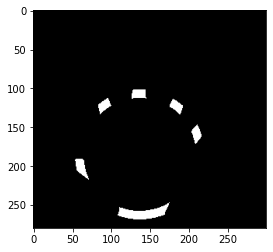

In [7]:
import matplotlib.pyplot as plt
external_contours = np.zeros(shape=thresholded.shape[:2])
for i in range(len(contours)):
    # external contour
    if hierarchy[0][i][3] == -1:
        cv.drawContours(image=external_contours, contours=contours, contourIdx=i, color=255, thickness=-1)
plt.imshow(external_contours, cmap="gray")

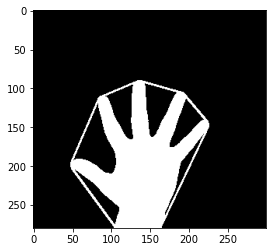

In [8]:
contours, hierarchy = cv.findContours(image=thresholded, mode=cv.RETR_EXTERNAL, method=cv.CHAIN_APPROX_SIMPLE)
external_contours = np.zeros(shape=thresholded.shape[:2])
hull=[]
for i in range(len(contours)):
    hull.append(cv.convexHull(contours[i], False))
    if hierarchy[0][i][3] == -1:
        cv.drawContours(image=external_contours, contours=contours, contourIdx=i, color=255, thickness=-1)
        cv.drawContours(external_contours, hull, i, (255, 0, 0), 2)
plt.imshow(external_contours, cmap="gray")